In [ ]:
# See some distinct road names and their link IDs
print(tbl[['LinkID', 'RoadName']].drop_duplicates().head(20))
# Or find all LinkIDs for a specific expressway or street:
ecp_links = tbl[tbl['RoadName'].str.contains('East Coast', na=False)]['LinkID'].unique()
print(ecp_links[:10])
print(ecp_links)


    LinkID                RoadName
0        2   NARAYANAN CHETTY ROAD
4        3   NARAYANAN CHETTY ROAD
8        4   NARAYANAN CHETTY ROAD
12       5   NARAYANAN CHETTY ROAD
16       6              LLOYD ROAD
20       7              LLOYD ROAD
24       8       RIVER VALLEY ROAD
28       9     MOHAMED SULTAN ROAD
32      10            BARTLEY ROAD
36      11     MOHAMED SULTAN ROAD
40      12        INSTITUTION HILL
44      13  MUTHURAMAN CHETTY ROAD
48      14             MARTIN ROAD
52      15             MARTIN ROAD
56      19            BARTLEY ROAD
60      20     MOHAMED SULTAN ROAD
64      21  MUTHURAMAN CHETTY ROAD
68      22             MARTIN ROAD
72      23       RIVER VALLEY ROAD
76      32       RIVER VALLEY ROAD
[]
[]


# Downloading all road LinkIDS and Maps

In [11]:
import requests
import pandas as pd

ACCOUNT_KEY = 'RYS6WoFQRNmktb5h2N0u5w=='   # your key
BASE_URL    = 'https://datamall2.mytransport.sg/ltaodataservice/v4/TrafficSpeedBands'

headers = {
    'AccountKey': ACCOUNT_KEY,
    'accept': 'application/json'
}

resp = requests.get(BASE_URL, headers=headers)
print("Status:", resp.status_code)
print("Raw text:", resp.text[:200])

if resp.status_code == 200:
    json_data = resp.json()
    records   = json_data.get('value', [])
    df = pd.DataFrame(records)
    print(df.head())
else:
    print("Request failed:", resp.text)


Status: 200
Raw text: {"odata.metadata":"https://datamall2.mytransport.sg/ltaodataservice/$metadata#TrafficSpeedBands","lastUpdatedTime":"2025-10-28 01:50:00","value":[{"LinkID":"2","RoadName":"NARAYANAN CHETTY ROAD","Road
  LinkID               RoadName RoadCategory  SpeedBand MinimumSpeed  \
0      2  NARAYANAN CHETTY ROAD            5          4           30   
1      3  NARAYANAN CHETTY ROAD            5          1            0   
2      4  NARAYANAN CHETTY ROAD            5          1            0   
3      5  NARAYANAN CHETTY ROAD            5          2           10   
4      6             LLOYD ROAD            5          1            0   

  MaximumSpeed    StartLon  StartLat      EndLon    EndLat  
0           39  103.838305   1.29206  103.838331  1.292044  
1            9  103.838523   1.29232  103.838419  1.292174  
2            9  103.838419  1.292174  103.838358  1.292083  
3           19  103.838331  1.292044  103.838197  1.291819  
4            9  103.838512  1.297836  1

# Data Loading

Mounting Drive Folder

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pandas as pd
BASE = "/content/drive/MyDrive/FYP-Datasets-2"  # centralized CSVs live here


Mounted at /content/drive


Tiny Reader for single CSV per feed

In [13]:
def read_csv(prefix, usecols=None):
    path = os.path.join(BASE, f"{prefix}.csv")
    return pd.read_csv(path, usecols=usecols, low_memory=False)


In [14]:
import os, pandas as pd
pd.read_csv(os.path.join(BASE, "LTA_incidents.csv"), nrows=3).columns.tolist()


['Roadwork',
 '(27/10)21:09 Road Works on TPE (towards SLE) at Loyang Avenue Entrance.',
 '1.362307524743189',
 '103.95902272970457',
 'ROADWORK',
 '(27/10)21:09 ROAD WORKS ON TPE (TOWARDS SLE) AT LOYANG AVENUE ENTRANCE.',
 '2025-10-27T13:23:08.285Z']

Load the 5 feeds

In [15]:
# --- column selections ---
sb_cols  = ["LinkID","RoadName","RoadCategory","SpeedBand","MinimumSpeed","MaximumSpeed","SpeedKMH_Est",
            "ts_15min","dow","hour","minute","bin_in_day","weekly_bin"]
ett_cols = ["Name","Direction","StartPoint","EndPoint","EstTravelTime","ts"]

inc_cols      = ["Type","Message","Latitude","Longitude","ts"]
inc_all_cols  = ["Type","Message","Latitude","Longitude","TYPE_UP","MSG_UP","ts"]

vms_cols      = ["EquipmentID","Message","ts"]
vms_all_cols  = ["EquipmentID","Road","Direction","Message","ts"]

cctv_cols     = ["CameraID","Latitude","Longitude","ImageLink","ts"]
cctv_all_cols = ["CameraID","Latitude","Longitude","ImageLink","ts"]

# --- load data (tolerant to missing/incorrect headers for incidents/vms/cctv) ---
df_speedbands     = read_csv("LTA_speedbands",     usecols=sb_cols)
df_esttraveltimes = read_csv("LTA_esttraveltimes", usecols=ett_cols)

# incidents
p_inc = os.path.join(BASE, "LTA_incidents.csv")
try:
    df_incidents = pd.read_csv(p_inc, usecols=inc_cols, low_memory=False)
except ValueError:
    df_incidents = pd.read_csv(p_inc, header=None, names=inc_all_cols, low_memory=False)[inc_cols]

# vms
try:
    df_vms = read_csv("LTA_vms", usecols=vms_cols)
except ValueError:
    p_vms = os.path.join(BASE, "LTA_vms.csv")
    df_vms = pd.read_csv(p_vms, header=None, names=vms_all_cols, low_memory=False)[vms_cols]

# cctv
try:
    df_cctv = read_csv("LTA_cctv", usecols=cctv_cols)
except ValueError:
    p_cctv = os.path.join(BASE, "LTA_cctv.csv")
    df_cctv = pd.read_csv(p_cctv, header=None, names=cctv_all_cols, low_memory=False)[cctv_cols]

# --- shapes ---
for n, df in {
    "speedbands": df_speedbands,
    "esttraveltimes": df_esttraveltimes,
    "incidents": df_incidents,
    "vms": df_vms,
    "cctv": df_cctv,
}.items():
    print(n, df.shape)


speedbands (500000, 13)
esttraveltimes (133964, 6)
incidents (2235, 5)
vms (73608, 3)
cctv (36000, 5)


If any single day file gets too huge

In [16]:
# def read_many_chunked(prefix, ts_col, usecols=None, chunksize=200_000):
#     import pandas as pd
#     parts = []
#     for p in files_for(prefix):
#         for chunk in pd.read_csv(p, usecols=usecols, chunksize=chunksize, low_memory=False):
#             # (we already filtered by filename/day; no need to filter timestamps here)
#             parts.append(chunk)
#     return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=usecols or [])


Clean speedbands + basic features

In [17]:
# --- Clean speedbands + basic features
import pandas as pd
import numpy as np

sb = df_speedbands.copy()

# 1) time → 15-min UTC bin
sb["bin15"] = pd.to_datetime(sb["ts_15min"], utc=True, errors="coerce")
sb = sb.dropna(subset=["bin15"])

# 2) numerics
num_cols = ["SpeedBand","MinimumSpeed","MaximumSpeed","SpeedKMH_Est"]
for c in num_cols:
    sb[c] = pd.to_numeric(sb[c], errors="coerce")

# 3) fill SpeedKMH_Est if missing with (min+max)/2 when available
mask_est = sb["SpeedKMH_Est"].isna() & sb["MinimumSpeed"].notna() & sb["MaximumSpeed"].notna()
sb.loc[mask_est, "SpeedKMH_Est"] = (sb.loc[mask_est, "MinimumSpeed"] + sb.loc[mask_est, "MaximumSpeed"]) / 2

# 4) keep plausible rows
sb = sb[(sb["MinimumSpeed"] >= 0) & (sb["MaximumSpeed"] >= 0)]
sb = sb[sb["SpeedBand"].between(1, 8, inclusive="both")]

# 5) dedupe per (LinkID, bin15) — keep last seen
sb = sb.sort_values("bin15").drop_duplicates(["LinkID","bin15"], keep="last")

# 6) engineered time features
sb["dow"]  = sb["bin15"].dt.dayofweek
sb["hour"] = sb["bin15"].dt.hour


sb["label_congested"] = (sb["SpeedBand"] <= 3).astype("Int64")

print("speedbands cleaned:", sb.shape)
display(sb.head(3))


speedbands cleaned: (499325, 15)


,LinkID,RoadName,RoadCategory,SpeedBand,MinimumSpeed,MaximumSpeed,SpeedKMH_Est,ts_15min,dow,hour,minute,bin_in_day,weekly_bin,bin15,label_congested
0,2,NARAYANAN CHETTY ROAD,5,2.0,10,19,14.5,2025-10-01T09:30:00.000Z,2,9,30,38,326,2025-10-01 09:30:00+00:00,1
66620,99666,JALAN LOYANG BESAR,5,3.0,20,29,24.5,2025-10-01T09:30:00.000Z,2,9,30,38,326,2025-10-01 09:30:00+00:00,1
66619,99664,PASIR RIS DRIVE 10,4,5.0,40,49,44.5,2025-10-01T09:30:00.000Z,2,9,30,38,326,2025-10-01 09:30:00+00:00,0


Aggregate the other feeds to 15 mins bins

In [18]:
# --- incidents per 15-min
inc = df_incidents.copy()
inc["bin15"] = pd.to_datetime(inc["ts"], utc=True, errors="coerce").dt.floor("15min")
inc_agg = (inc.dropna(subset=["bin15"])
             .groupby("bin15", as_index=False)
             .size()
             .rename(columns={"size":"incident_count"}))

# --- VMS per 15-min
vms = df_vms.copy()
vms["bin15"] = pd.to_datetime(vms["ts"], utc=True, errors="coerce").dt.floor("15min")
vms_agg = (vms.dropna(subset=["bin15"])
             .groupby("bin15", as_index=False)
             .size()
             .rename(columns={"size":"vms_count"}))

# --- CCTV per 15-min
cctv = df_cctv.copy()
cctv["bin15"] = pd.to_datetime(cctv["ts"], utc=True, errors="coerce").dt.floor("15min")
cctv_agg = (cctv.dropna(subset=["bin15"])
              .groupby("bin15", as_index=False)
              .size()
              .rename(columns={"size":"cctv_count"}))

# --- Est. travel time per 15-min (mean)
ett = df_esttraveltimes.copy()
ett["bin15"] = pd.to_datetime(ett["ts"], utc=True, errors="coerce").dt.floor("15min")
ett["EstTravelTime"] = pd.to_numeric(ett["EstTravelTime"], errors="coerce")
ett_agg = (ett.dropna(subset=["bin15"])
             .groupby("bin15", as_index=False)["EstTravelTime"]
             .mean()
             .rename(columns={"EstTravelTime":"ett_mean"}))

# quick shapes and ranges
def _rng(df, col="bin15"):
    return (df[col].min(), df[col].max()) if len(df) else (None, None)

print("inc_agg  :", inc_agg.shape,  "range:", _rng(inc_agg))
print("vms_agg  :", vms_agg.shape,  "range:", _rng(vms_agg))
print("cctv_agg :", cctv_agg.shape, "range:", _rng(cctv_agg))
print("ett_agg  :", ett_agg.shape,  "range:", _rng(ett_agg))


inc_agg  : (18, 2) range: (Timestamp('2025-10-27 13:15:00+0000', tz='UTC'), Timestamp('2025-10-27 17:45:00+0000', tz='UTC'))
vms_agg  : (302, 2) range: (Timestamp('2025-10-20 09:00:00+0000', tz='UTC'), Timestamp('2025-10-27 17:45:00+0000', tz='UTC'))
cctv_agg : (2, 2) range: (Timestamp('2025-10-01 10:00:00+0000', tz='UTC'), Timestamp('2025-10-01 11:00:00+0000', tz='UTC'))
ett_agg  : (698, 2) range: (Timestamp('2025-10-01 09:30:00+0000', tz='UTC'), Timestamp('2025-10-27 15:00:00+0000', tz='UTC'))


Assemble one modeling table + save

In [19]:
# --- Assemble one modeling table (join on bin15 only)
keep_cols = ["LinkID","RoadName","SpeedBand","MinimumSpeed","MaximumSpeed",
             "SpeedKMH_Est","bin15","dow","hour","label_congested"]

tbl = (sb[keep_cols]
       .merge(inc_agg,  on="bin15", how="left")
       .merge(vms_agg,  on="bin15", how="left")
       .merge(cctv_agg, on="bin15", how="left")
       .merge(ett_agg,  on="bin15", how="left"))

# fill NA for counts and ett
for c in ["incident_count","vms_count","cctv_count"]:
    if c in tbl.columns:
        tbl[c] = tbl[c].fillna(0).astype(int)
if "ett_mean" in tbl.columns:
    if tbl["ett_mean"].notna().any():
        tbl["ett_mean"] = tbl["ett_mean"].fillna(tbl["ett_mean"].median())
    else:
        tbl["ett_mean"] = 0.0

print("modeling table:", tbl.shape)
display(tbl.head(3))

# save for next steps (Option A shifting/training will use this)
OUT_DIR = "/content"
out_path = f"{OUT_DIR}/model_table_rolling.csv"
tbl.to_csv(out_path, index=False)
print("Saved:", out_path)


modeling table: (499325, 14)


,LinkID,RoadName,SpeedBand,MinimumSpeed,MaximumSpeed,SpeedKMH_Est,bin15,dow,hour,label_congested,incident_count,vms_count,cctv_count,ett_mean
0,2,NARAYANAN CHETTY ROAD,2.0,10,19,14.5,2025-10-01 09:30:00+00:00,2,9,1,0,0,0,1.962766
1,99666,JALAN LOYANG BESAR,3.0,20,29,24.5,2025-10-01 09:30:00+00:00,2,9,1,0,0,0,1.962766
2,99664,PASIR RIS DRIVE 10,5.0,40,49,44.5,2025-10-01 09:30:00+00:00,2,9,0,0,0,0,1.962766


Saved: /content/model_table_rolling.csv


Create next-bin label

In [20]:
# predict congestion in the NEXT 15-min bin
tbl = tbl.sort_values(["LinkID", "bin15"]).copy()
tbl["label_next"] = tbl.groupby("LinkID")["label_congested"].shift(-1)
tbl = tbl.dropna(subset=["label_next"]).reset_index(drop=True)

print("Rows with next-bin target:", tbl.shape)
print("Bins span:", tbl["bin15"].min(), "→", tbl["bin15"].max())

Rows with next-bin target: (399459, 15)
Bins span: 2025-10-01 09:30:00+00:00 → 2025-10-01 10:15:00+00:00


In [21]:
# # Sneak peek
# print(tbl.shape)
# tbl.head(10)


# Exploratory Data Analysis

Quick Label Balance and basic stats

In [22]:
import numpy as np
pd.set_option("display.float_format", lambda v: f"{v:,.3f}")

print("rows:", len(tbl))
print("unique links:", tbl["LinkID"].nunique())
print("time bins:", tbl["bin15"].nunique())

# label balance
lbl = tbl["label_congested"].value_counts(dropna=False).rename({0:"non-congested",1:"congested"})
print("\nLabel balance:\n", lbl)
print("\nShare congested:", (tbl["label_congested"]==1).mean().round(3))

# basic speed stats (cap extreme 999-derived values for the summary only)
speed = tbl["SpeedKMH_Est"].clip(upper=120)
print("\nSpeedKMH_Est (clipped @120) describe:\n", speed.describe())


rows: 399459
unique links: 99865
time bins: 4

Label balance:
 label_congested
congested        251858
non-congested    147601
Name: count, dtype: Int64

Share congested: 0.63

SpeedKMH_Est (clipped @120) describe:
 count   399,459.000
mean         26.224
std          18.907
min           4.500
25%          14.500
50%          24.500
75%          34.500
max         120.000
Name: SpeedKMH_Est, dtype: float64


Congestion rate by hour / day of week

In [23]:
# by hour
hour_rate = (tbl.groupby("hour")["label_congested"]
               .mean().reset_index().rename(columns={"label_congested":"cong_rate"}))
print("Congestion rate by hour:\n", hour_rate)

# by day-of-week (0=Mon)
dow_rate = (tbl.groupby("dow")["label_congested"]
              .mean().reset_index().rename(columns={"label_congested":"cong_rate"}))
print("\nCongestion rate by day-of-week:\n", dow_rate)


Congestion rate by hour:
    hour  cong_rate
0     9      0.626
1    10      0.635

Congestion rate by day-of-week:
    dow  cong_rate
0    2      0.630


Small plots (hist + hourly profile)

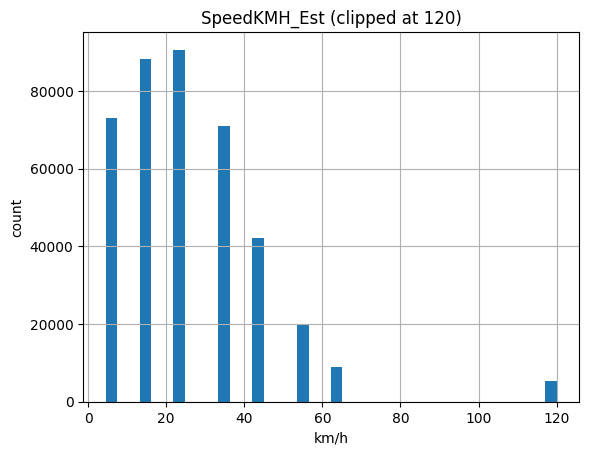

<Figure size 640x480 with 0 Axes>

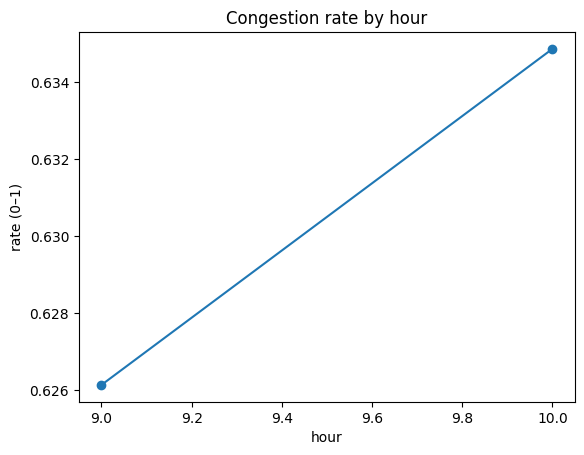

In [24]:
import matplotlib.pyplot as plt

# Speed histogram (clipped for readability)
plt.figure()
tbl["SpeedKMH_Est"].clip(upper=120).dropna().hist(bins=40)
plt.title("SpeedKMH_Est (clipped at 120)")
plt.xlabel("km/h"); plt.ylabel("count")
plt.show()

# Hourly congestion profile
plt.figure()
hour_rate.plot(x="hour", y="cong_rate", kind="line", marker="o", legend=False)
plt.title("Congestion rate by hour")
plt.xlabel("hour"); plt.ylabel("rate (0–1)")
plt.show()


Quick feature-target sanity checks

In [25]:
# Relationship: lower speed ⇢ higher congestion
print("Mean speed by label (0=non,1=cong):")
print(tbl.groupby("label_congested")["SpeedKMH_Est"].mean())

# Do global signals move with congestion?
for col in ["incident_count","vms_count","cctv_count","ett_mean"]:
    if col in tbl.columns:
        try:
            corr = tbl[[col,"label_congested"]].corr().iloc[0,1]
        except Exception:
            corr = np.nan
        print(f"Corr({col}, label) =", round(float(corr), 3))


Mean speed by label (0=non,1=cong):
label_congested
0   60.287
1   15.193
Name: SpeedKMH_Est, dtype: float64
Corr(incident_count, label) = nan
Corr(vms_count, label) = nan
Corr(cctv_count, label) = 0.001
Corr(ett_mean, label) = 0.007


Distributions (speed band with clipped speed)

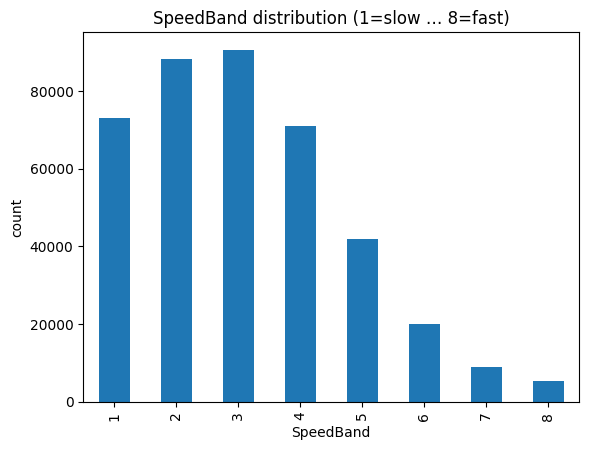

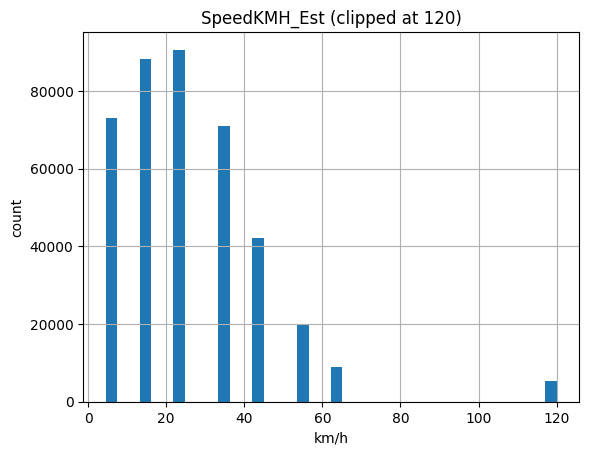

In [26]:
import matplotlib.pyplot as plt

# SpeedBand distribution
plt.figure()
(tbl["SpeedBand"].dropna().astype(int)).value_counts().sort_index().plot(kind="bar")
plt.title("SpeedBand distribution (1=slow … 8=fast)")
plt.xlabel("SpeedBand"); plt.ylabel("count")
plt.show()

# SpeedKMH_Est histogram (clipped for readability)
plt.figure()
tbl["SpeedKMH_Est"].clip(upper=120).dropna().hist(bins=40)
plt.title("SpeedKMH_Est (clipped at 120)")
plt.xlabel("km/h"); plt.ylabel("count")
plt.show()


Congestion rate by RoadCategory and by RoadName

RoadCategory
5   0.821
4   0.685
6   0.568
3   0.458
2   0.318
8   0.111
1   0.058
Name: label_congested, dtype: Float64
RoadCategory
5   0.821
4   0.685
6   0.568
3   0.458
2   0.318
8   0.111
1   0.058
Name: label_congested, dtype: Float64


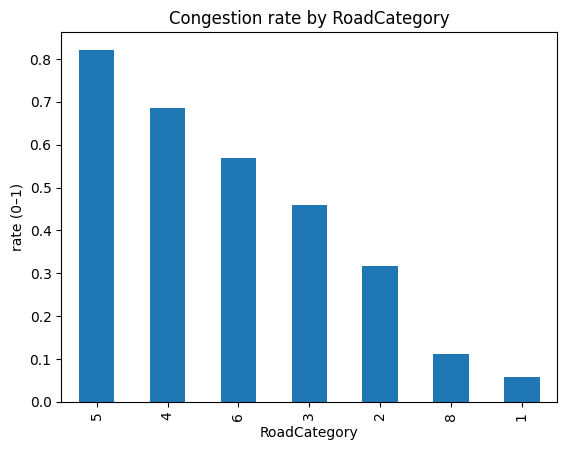

                      n  rate
RoadName                     
YUNNAN WALK 1        56 1.000
WOODLANDS DRIVE 72   56 1.000
ALJUNIED AVENUE 5    76 1.000
WALLICH STREET       96 1.000
WALSHE ROAD         152 1.000
WESTWOOD WALK        56 1.000
WIMBORNE ROAD        56 1.000
WARINGIN PARK        68 1.000
WATTEN HEIGHTS       60 1.000
WATTEN RISE          56 1.000
WATTEN TERRACE       68 1.000
TEMASEK BOULEVARD    88 1.000
TUAS VIEW LOOP       60 1.000
VENUS ROAD           56 1.000
THE INGLEWOOD        80 1.000


/tmp/ipython-input-1225462662.py:29: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("n >= 50")


<Figure size 640x480 with 0 Axes>

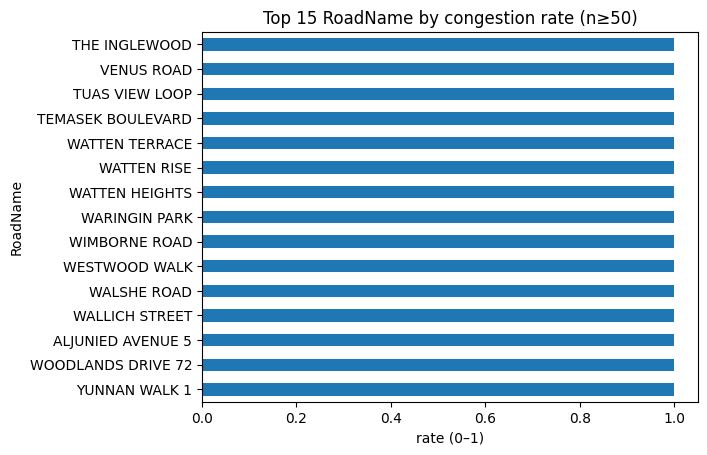

In [27]:
# Patch: add RoadCategory into the modeling table
if "RoadCategory" not in tbl.columns:
    tbl = tbl.merge(
        sb[["LinkID","bin15","RoadCategory"]],
        on=["LinkID","bin15"],
        how="left"
    )

# Now this will work:
rate_cat = (tbl.groupby("RoadCategory")["label_congested"]
              .mean().sort_values(ascending=False))
print(rate_cat)


# By RoadCategory
rate_cat = (tbl.groupby("RoadCategory")["label_congested"]
              .mean().sort_values(ascending=False))
print(rate_cat)

plt.figure()
rate_cat.plot(kind="bar")
plt.title("Congestion rate by RoadCategory")
plt.xlabel("RoadCategory"); plt.ylabel("rate (0–1)")
plt.show()

# Top road names by congestion rate (only if enough samples)
g = (tbl.groupby("RoadName")
       .agg(n=("label_congested","size"), rate=("label_congested","mean"))
       .query("n >= 50")
       .sort_values("rate", ascending=False)
       .head(15))
print(g)

plt.figure()
g.sort_values("rate").plot(y="rate", kind="barh", legend=False)
plt.title("Top 15 RoadName by congestion rate (n≥50)")
plt.xlabel("rate (0–1)"); plt.ylabel("RoadName")
plt.show()


Time Pattern Heatmap (hour by day-of-week)

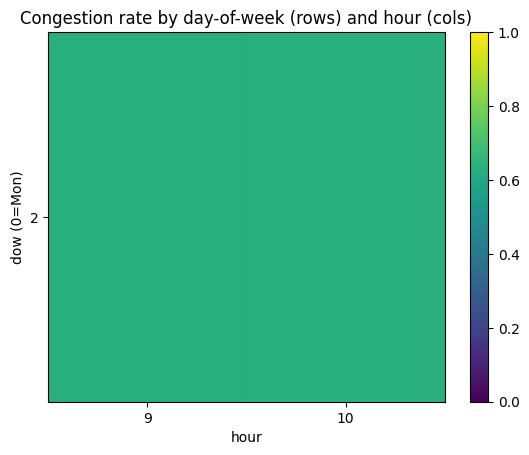

In [28]:
import numpy as np
import matplotlib.pyplot as plt

pivot = tbl.pivot_table(index="dow", columns="hour", values="label_congested", aggfunc="mean")

if pivot.size == 0:
    print("Not enough time bins yet for heatmap.")
else:
    A = pivot.to_numpy(dtype=float)  # ensure numeric
    plt.figure()
    plt.imshow(A, aspect="auto", interpolation="nearest", vmin=0, vmax=1)
    plt.title("Congestion rate by day-of-week (rows) and hour (cols)")
    plt.xlabel("hour"); plt.ylabel("dow (0=Mon)")
    plt.xticks(np.arange(A.shape[1]), pivot.columns)
    plt.yticks(np.arange(A.shape[0]), pivot.index)
    plt.colorbar()
    plt.show()


Bin - level relationships (incidents / VMS / EstTimeTrav / vs Congestion)

                           bin15  cong_rate  incident_count  vms_count  \
count                          4      4.000           4.000      4.000   
mean   2025-10-01 09:52:30+00:00      0.630           0.000      0.000   
min    2025-10-01 09:30:00+00:00      0.624           0.000      0.000   
25%    2025-10-01 09:41:15+00:00      0.627           0.000      0.000   
50%    2025-10-01 09:52:30+00:00      0.630           0.000      0.000   
75%    2025-10-01 10:03:45+00:00      0.633           0.000      0.000   
max    2025-10-01 10:15:00+00:00      0.639           0.000      0.000   
std                          NaN      0.006           0.000      0.000   

       ett_mean  
count     4.000  
mean      2.004  
min       1.963  
25%       1.991  
50%       2.011  
75%       2.024  
max       2.032  
std       0.030  


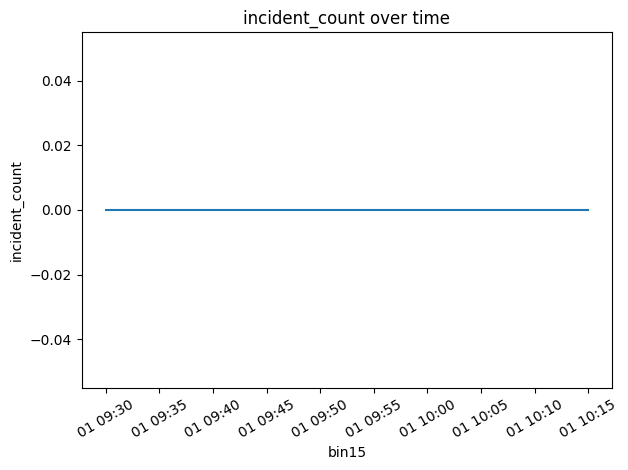

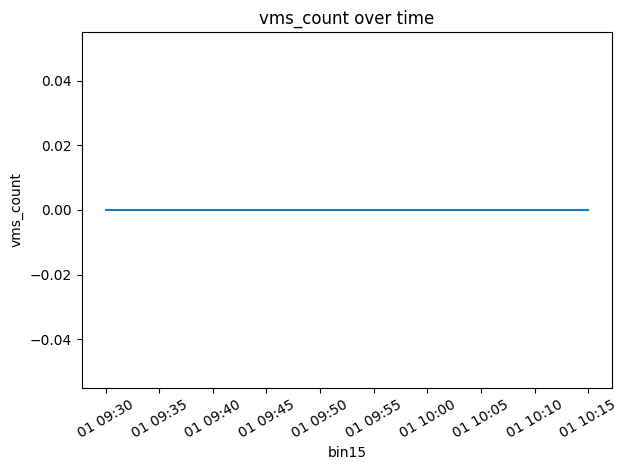

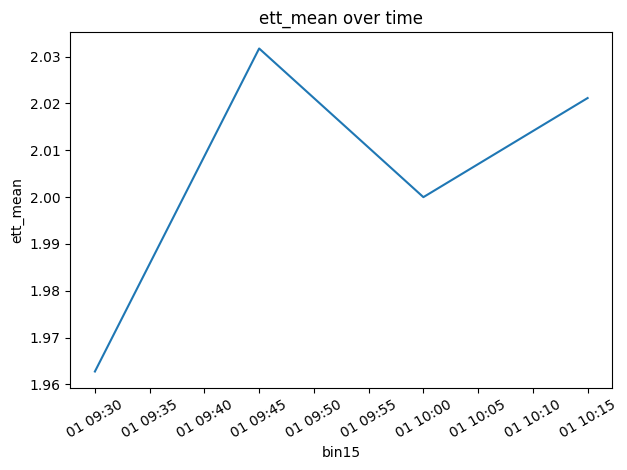

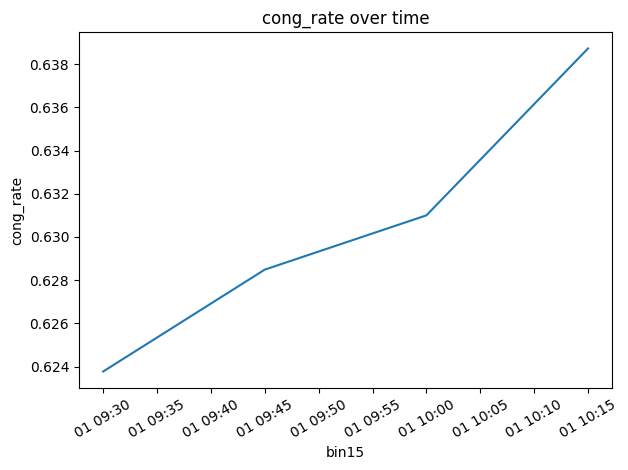

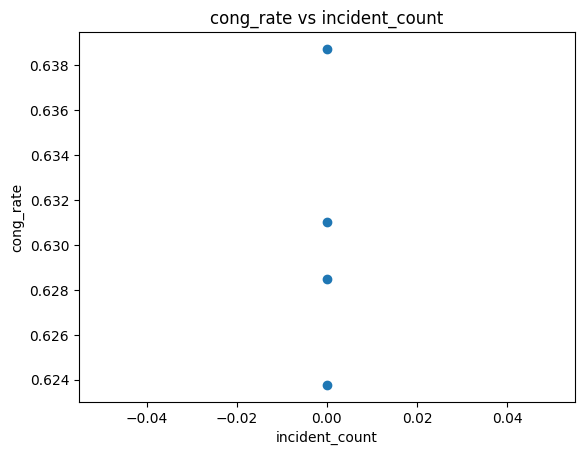

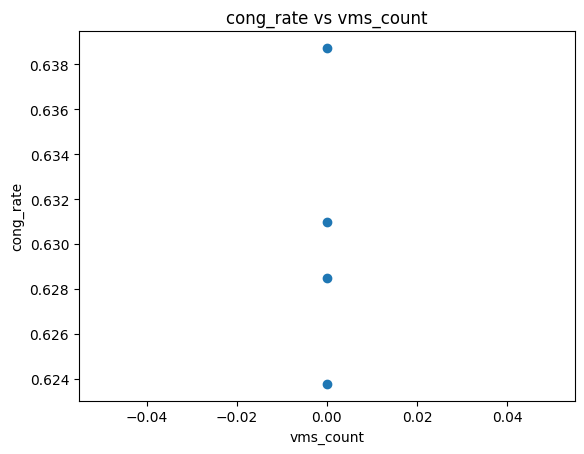

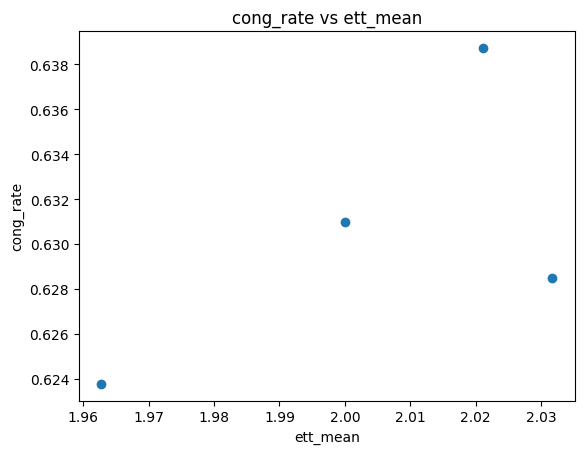

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recompute 15-min bin aggregates (self-contained)
bin_rate = (tbl.groupby("bin15", as_index=False)
              .agg(cong_rate=("label_congested","mean")))

inc_agg_ = (df_incidents.assign(bin15=pd.to_datetime(df_incidents["ts"], utc=True, errors="coerce").dt.floor("15min"))
                        .groupby("bin15", as_index=False).agg(incident_count=("Type","size")))

vms_agg_ = (df_vms.assign(bin15=pd.to_datetime(df_vms["ts"], utc=True, errors="coerce").dt.floor("15min"))
                    .groupby("bin15", as_index=False).agg(vms_count=("Message","size")))

ett_agg_ = (df_esttraveltimes.assign(bin15=pd.to_datetime(df_esttraveltimes["ts"], utc=True, errors="coerce").dt.floor("15min"),
                                     EstTravelTime=pd.to_numeric(df_esttraveltimes["EstTravelTime"], errors="coerce"))
                        .groupby("bin15", as_index=False).agg(ett_mean=("EstTravelTime","mean")))

bin_features = (bin_rate.merge(inc_agg_, on="bin15", how="left")
                        .merge(vms_agg_, on="bin15", how="left")
                        .merge(ett_agg_, on="bin15", how="left"))

# Fill NaNs for counts; leave ett_mean as is
for c in ["incident_count","vms_count"]:
    if c in bin_features: bin_features[c] = bin_features[c].fillna(0).astype(int)

print(bin_features.describe(include="all"))

# Time series (will be short now; fine)
for col in ["incident_count","vms_count","ett_mean","cong_rate"]:
    if col in bin_features.columns:
        plt.figure()
        plt.plot(bin_features["bin15"], bin_features[col])
        plt.title(f"{col} over time")
        plt.xlabel("bin15"); plt.ylabel(col)
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

# Scatter: features vs congestion rate
for col in ["incident_count","vms_count","ett_mean"]:
    if col in bin_features.columns:
        df_sc = bin_features[[col,"cong_rate"]].dropna()
        if len(df_sc) > 1:
            plt.figure()
            plt.scatter(df_sc[col], df_sc["cong_rate"])
            plt.title(f"cong_rate vs {col}")
            plt.xlabel(col); plt.ylabel("cong_rate")
            plt.show()


Congestion rate vs speed curve (robust)

   speed_binned  label_congested
0         0.000            1.000
1        10.000            1.000
2        20.000            1.000
3        30.000            0.000
4        40.000            0.000
5        50.000            0.000
6        60.000            0.000
7       120.000            0.000


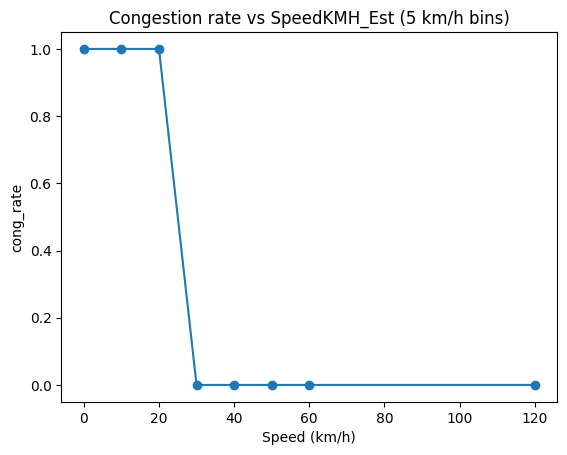

In [30]:
q = tbl.copy()

# ensure numeric speed; clip for readability; drop NaN/neg
q["SpeedKMH_Est"] = pd.to_numeric(q["SpeedKMH_Est"], errors="coerce").clip(lower=0, upper=120)
q = q.dropna(subset=["SpeedKMH_Est", "label_congested"])

# 5 km/h bins
q["speed_binned"] = (q["SpeedKMH_Est"] // 5) * 5
curve = (q.groupby("speed_binned")["label_congested"]
          .mean().reset_index().sort_values("speed_binned"))

print(curve.head(10))

plt.figure()
plt.plot(curve["speed_binned"], curve["label_congested"], marker="o")
plt.title("Congestion rate vs SpeedKMH_Est (5 km/h bins)")
plt.xlabel("Speed (km/h)"); plt.ylabel("cong_rate")
plt.show()

# Model Training

Building features (tiny, numeric only)

In [31]:
# keep simple numeric features
FEATS = [
    "SpeedKMH_Est","MinimumSpeed","MaximumSpeed",
    "dow","hour","incident_count","vms_count","cctv_count","ett_mean"
]

tmp = tbl.copy()

# cap obvious outliers
tmp["SpeedKMH_Est"] = pd.to_numeric(tmp["SpeedKMH_Est"], errors="coerce").clip(0, 120)
tmp["MinimumSpeed"] = pd.to_numeric(tmp["MinimumSpeed"], errors="coerce").clip(0, 120)
tmp["MaximumSpeed"] = pd.to_numeric(tmp["MaximumSpeed"], errors="coerce").clip(0, 120)

# ensure counts/ETT exist
for c in ["incident_count","vms_count","cctv_count"]:
    if c not in tmp.columns:
        tmp[c] = 0
    tmp[c] = pd.to_numeric(tmp[c], errors="coerce").fillna(0).astype(int)

tmp["ett_mean"] = pd.to_numeric(tmp.get("ett_mean"), errors="coerce").fillna(0.0)

# require target & time
tmp = tmp.dropna(subset=["label_next","bin15"]).copy()

# final matrices
X = tmp[FEATS].copy()
y = tmp["label_next"].astype(int)
t = pd.to_datetime(tmp["bin15"], utc=True)

print("X:", X.shape, " y:", y.shape, " unique bins:", t.nunique())
print(X.head(5))


X: (399459, 9)  y: (399459,)  unique bins: 4
   SpeedKMH_Est  MinimumSpeed  MaximumSpeed  dow  hour  incident_count  \
0        14.500            10            19    2     9               0   
1        14.500            10            19    2     9               0   
2        14.500            10            19    2    10               0   
3        14.500            10            19    2    10               0   
4         4.500             0             9    2     9               0   

   vms_count  cctv_count  ett_mean  
0          0           0     1.963  
1          0           0     2.032  
2          0       18000     2.000  
3          0           0     2.021  
4          0           0     1.963  


Time-based split (train → past, valid → most recent bin)

In [32]:
# sort by time; take the most recent bin for validation
import numpy as np
order = np.argsort(t.values)
X_sorted, y_sorted, t_sorted = X.iloc[order], y.iloc[order], t.iloc[order]

unique_bins = t_sorted.drop_duplicates().sort_values()

if len(unique_bins) < 2:
    # fallback: single-bin data → simple row split
    split = int(len(X_sorted) * 0.8)
    X_tr, y_tr = X_sorted.iloc[:split], y_sorted.iloc[:split]
    X_va, y_va = X_sorted.iloc[split:], y_sorted.iloc[split:]
    last_bin = unique_bins.iloc[-1] if len(unique_bins) else None
else:
    last_bin = unique_bins.iloc[-1]
    mask_va = (t_sorted == last_bin)
    X_va, y_va = X_sorted[mask_va], y_sorted[mask_va]
    X_tr, y_tr = X_sorted[~mask_va], y_sorted[~mask_va]

print("train:", X_tr.shape, "valid:", X_va.shape, "last_bin:", str(last_bin))


train: (299594, 9) valid: (99865, 9) last_bin: 2025-10-01 10:15:00+00:00


Fit a small classifier (no scaling, and handles NaNs)

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(
    max_depth=None,      # let it grow (still small)
    learning_rate=0.1,
    max_iter=200,
    random_state=42
)
clf.fit(X_tr, y_tr)

# quick train/valid preds
p_tr = clf.predict_proba(X_tr)[:,1]
p_va = clf.predict_proba(X_va)[:,1]


Quick metrics

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

th = 0.5
yhat_va = (p_va >= th).astype(int)

def show_metrics(split, y_true, p):
    yhat = (p >= th).astype(int)
    print(f"\n[{split}]")
    print("AUC :", round(roc_auc_score(y_true, p), 3))
    print("ACC :", round(accuracy_score(y_true, yhat), 3))
    print("F1  :", round(f1_score(y_true, yhat), 3))
    print("CM  :\n", confusion_matrix(y_true, yhat))

show_metrics("train", y_tr, p_tr)
show_metrics("valid", y_va, p_va)



[train]
AUC : 0.921
ACC : 0.874
F1  : 0.9
CM  :
 [[ 91852  18177]
 [ 19671 169894]]

[valid]
AUC : 0.906
ACC : 0.857
F1  : 0.888
CM  :
 [[28776  6967]
 [ 7302 56820]]


Export the model

In [35]:
import joblib, os, json

EXPORT_DIR = "/content"
os.makedirs(EXPORT_DIR, exist_ok=True)

joblib.dump({"model": clf, "features": FEATS}, f"{EXPORT_DIR}/congestion_model.pkl")
with open(f"{EXPORT_DIR}/congestion_model.meta.json","w") as f:
    json.dump({"features": FEATS}, f, indent=2)

print("Saved:",
      f"{EXPORT_DIR}/congestion_model.pkl",
      "and",
      f"{EXPORT_DIR}/congestion_model.meta.json")


Saved: /content/congestion_model.pkl and /content/congestion_model.meta.json


Explore testing

In [36]:
import pandas as pd, joblib
FEATS = ["SpeedKMH_Est","MinimumSpeed","MaximumSpeed","dow","hour","incident_count","vms_count","cctv_count","ett_mean"]

samples = pd.DataFrame([
    {"SpeedKMH_Est":28.0,"MinimumSpeed":20.0,"MaximumSpeed":29.0,"dow":3,"hour":9,"incident_count":74,"vms_count":360,"cctv_count":36000,"ett_mean":1.82},
    {"SpeedKMH_Est":64.5,"MinimumSpeed":60.0,"MaximumSpeed":69.0,"dow":3,"hour":9,"incident_count":73,"vms_count":348,"cctv_count":36000,"ett_mean":1.80},
])[FEATS]

mdl = joblib.load("/content/congestion_model.pkl")["model"]
proba = mdl.predict_proba(samples)[:,1]
#proba
pretty = pd.DataFrame({
    "congestion_next15": (proba * 100).round(1).astype(str) + "%",
    "status": np.where(proba >= 0.5, "congested", "clear"),
})
print(pretty)

  congestion_next15     status
0             79.2%  congested
1              2.1%      clear


Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# (reuse X_tr, y_tr from your split cell)
final_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
final_model.fit(X_tr, y_tr)

joblib.dump(final_model, "/content/rf.joblib")
joblib.dump(FEATS, "/content/feature_columns.joblib")
print("Saved: /content/rf.joblib")


Saved: /content/rf.joblib


Quick Feature Importance

In [38]:
import pandas as pd

imp = pd.Series(final_model.feature_importances_, index=FEATS).sort_values(ascending=False)
print(imp.round(3))


SpeedKMH_Est     0.359
MinimumSpeed     0.335
MaximumSpeed     0.305
ett_mean         0.000
cctv_count       0.000
hour             0.000
dow              0.000
vms_count        0.000
incident_count   0.000
dtype: float64


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict probabilities on the validation set (you already have X_va and y_va from earlier)
p_va = final_model.predict_proba(X_va)[:, 1]
yhat_va = (p_va >= 0.5).astype(int)

validation_auc = roc_auc_score(y_va, p_va)
validation_acc = accuracy_score(y_va, yhat_va)
validation_f1 = f1_score(y_va, yhat_va)
cm = confusion_matrix(y_va, yhat_va)

print("Validation AUC :", validation_auc)
print("Validation ACC :", validation_acc)
print("Validation F1  :", validation_f1)
print("Confusion matrix:\n", cm)


Validation AUC : 0.9060056065505038
Validation ACC : 0.8571171080959296
Validation F1  : 0.8884441282474259
Confusion matrix:
 [[28776  6967]
 [ 7302 56820]]


In [40]:
# Convert the NumPy array to a Python list before saving
metrics = {
    "auc": validation_auc,
    "accuracy": validation_acc,
    "f1": validation_f1,
    "confusion_matrix": cm.tolist()
}
with open("rf_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics to rf_metrics.json")

Saved metrics to rf_metrics.json


In [41]:
import pandas as pd

def aggregate_route_features(route_segment_ids, segment_df):
    """
    route_segment_ids: list of LinkID values making up the route in order.
    segment_df: DataFrame with per‑segment features (same columns as your training data).
    Returns a dictionary of aggregated features for the route.
    """
    segs = segment_df[segment_df['LinkID'].isin(route_segment_ids)]
    feat = {}
    # example aggregations – adjust as needed
    feat['avg_speed'] = segs['SpeedKMH_Est'].mean()
    feat['min_speed'] = segs['SpeedKMH_Est'].min()
    feat['max_speed'] = segs['SpeedKMH_Est'].max()
    feat['incident_count'] = segs['incident_count'].sum()
    feat['vms_count'] = segs['vms_count'].sum()
    feat['cctv_count'] = segs['cctv_count'].sum()
    feat['avg_ett'] = segs['ett_mean'].mean()
    # include day-of-week and hour-of-day based on departure time
    return feat

# Example usage:
# example_route = ['LinkA', 'LinkB', 'LinkC']
# route_features = aggregate_route_features(example_route, tbl)


In [42]:
# These LinkID values are placeholders, not real segment IDs.
routes = [
    {
        'route_id': 'orchard_to_changi',
        'from': 'Orchard Road',
        'to': 'Changi Airport',
        'link_ids': ['L10','L20','L30','L40']
    },
    {
        'route_id': 'sentosa_to_marina_bay',
        'from': 'Sentosa',
        'to': 'Marina Bay Sands',
        'link_ids': ['L50','L60','L70']
    },
    {
        'route_id': 'bukit_panjang_to_tampines',
        'from': 'Bukit Panjang',
        'to': 'Tampines',
        'link_ids': ['L80','L90','L100']
    }
]

# Aggregate features for each route
route_rows = []
for r in routes:
    feats = aggregate_route_features(r['link_ids'], tbl)
    feats['route_id'] = r['route_id']
    feats['from'] = r['from']
    feats['to'] = r['to']
    route_rows.append(feats)

route_features_df = pd.DataFrame(route_rows)
display(route_features_df)


,avg_speed,min_speed,max_speed,incident_count,vms_count,cctv_count,avg_ett,route_id,from,to
0,NaN,NaN,NaN,0,0,0,NaN,orchard_to_changi,Orchard Road,Changi Airport
1,NaN,NaN,NaN,0,0,0,NaN,sentosa_to_marina_bay,Sentosa,Marina Bay Sands
2,NaN,NaN,NaN,0,0,0,NaN,bukit_panjang_to_tampines,Bukit Panjang,Tampines


Inspect available LinkIDs and road names to see which roads and LinkIDs are available

In [56]:
# See some distinct road names and their link IDs
print(tbl[['LinkID', 'RoadName']].drop_duplicates().head(20))
# Or find all LinkIDs for a specific expressway or street:
ecp_links = tbl[tbl['RoadName'].str.contains('East Coast', na=False)]['LinkID'].unique()
print(ecp_links[:10])
print(ecp_links)


    LinkID                RoadName
0        2   NARAYANAN CHETTY ROAD
4        3   NARAYANAN CHETTY ROAD
8        4   NARAYANAN CHETTY ROAD
12       5   NARAYANAN CHETTY ROAD
16       6              LLOYD ROAD
20       7              LLOYD ROAD
24       8       RIVER VALLEY ROAD
28       9     MOHAMED SULTAN ROAD
32      10            BARTLEY ROAD
36      11     MOHAMED SULTAN ROAD
40      12        INSTITUTION HILL
44      13  MUTHURAMAN CHETTY ROAD
48      14             MARTIN ROAD
52      15             MARTIN ROAD
56      19            BARTLEY ROAD
60      20     MOHAMED SULTAN ROAD
64      21  MUTHURAMAN CHETTY ROAD
68      22             MARTIN ROAD
72      23       RIVER VALLEY ROAD
76      32       RIVER VALLEY ROAD
[]
[]


In [44]:
roads = ['KENT ROAD', 'SHREWSBURY ROAD', 'ORCHARD SPRING LANE', 'BUCKLEY ROAD', 'KAY SIANG ROAD']

# Build a dictionary of LinkIDs for each road
road_links = {}
for road in roads:
    ids = tbl[tbl['RoadName'] == road]['LinkID'].unique()
    road_links[road] = ids
    print(f"{road}: {list(ids)}")  # see what you’ve got

# Now define routes using these real LinkIDs.
# Adjust the indices [0], [1] etc. depending on how many IDs each road has.
routes = [
    {
        'route_id': 'kent_to_orchard',
        'from': 'Kent Road',
        'to': 'Orchard Spring Lane',
        'link_ids': [
            road_links['KENT ROAD'][0],
            road_links['SHREWSBURY ROAD'][0],
            road_links['ORCHARD SPRING LANE'][0]
        ]
    },
    {
        'route_id': 'buckley_to_kay',
        'from': 'Buckley Road',
        'to': 'Kay Siang Road',
        'link_ids': [
            road_links['BUCKLEY ROAD'][0],
            road_links['ORCHARD SPRING LANE'][0],
            road_links['KAY SIANG ROAD'][0]
        ]
    },
    {
        'route_id': 'shrewsbury_to_kay',
        'from': 'Shrewsbury Road',
        'to': 'Kay Siang Road',
        'link_ids': [
            road_links['SHREWSBURY ROAD'][0],
            road_links['KENT ROAD'][0],
            road_links['KAY SIANG ROAD'][0]
        ]
    },
]

# Aggregate features for each route
route_rows = []
for r in routes:
    feats = aggregate_route_features(r['link_ids'], tbl)
    feats.update({
        'route_id': r['route_id'],
        'from': r['from'],
        'to': r['to']
    })
    route_rows.append(feats)

route_features_df = pd.DataFrame(route_rows)
display(route_features_df)

KENT ROAD: [np.int64(82316), np.int64(82322), np.int64(82693), np.int64(82694), np.int64(82902)]
SHREWSBURY ROAD: [np.int64(75023), np.int64(75024), np.int64(75025), np.int64(75071), np.int64(75077), np.int64(75078), np.int64(75079), np.int64(75080), np.int64(75081), np.int64(75096), np.int64(75097), np.int64(75099), np.int64(75141), np.int64(75144), np.int64(75145), np.int64(75146), np.int64(75147), np.int64(75148), np.int64(75152), np.int64(75359), np.int64(75360), np.int64(75361), np.int64(75362), np.int64(75363), np.int64(75364), np.int64(75365), np.int64(75368), np.int64(75369), np.int64(75370), np.int64(75371), np.int64(75372), np.int64(75373), np.int64(75374), np.int64(75375), np.int64(75376), np.int64(75541), np.int64(75542), np.int64(75556), np.int64(75590), np.int64(75594)]
ORCHARD SPRING LANE: [np.int64(30255), np.int64(30464), np.int64(30470), np.int64(32433), np.int64(32434), np.int64(32435), np.int64(32436), np.int64(33512), np.int64(33515), np.int64(33516), np.int64(3351

,avg_speed,min_speed,max_speed,incident_count,vms_count,cctv_count,avg_ett,route_id,from,to
0,14.500,4.500,24.500,0,0,54000,2.004,kent_to_orchard,Kent Road,Orchard Spring Lane
1,7.833,4.500,14.500,0,0,54000,2.004,buckley_to_kay,Buckley Road,Kay Siang Road
2,14.500,4.500,24.500,0,0,54000,2.004,shrewsbury_to_kay,Shrewsbury Road,Kay Siang Road


Scraping all road names

In [45]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [46]:
# Step 1: Scrape all road names from Geographic.org
url = "https://geographic.org/streetview/singapore/index.html"
resp = requests.get(url)
soup = BeautifulSoup(resp.text, "html.parser")

roads = [a.text.strip() for a in soup.select("a") if a.text.strip()]
roads = sorted(set([r for r in roads if any(x in r for x in
    ["Road", "Avenue", "Street", "Drive", "Lane", "Close", "Crescent"])]))

print(f"Total roads found: {len(roads)}")
print(roads[:20])  # preview


Total roads found: 2353
['Abingdon Road', 'Adam Drive', 'Adam Road', 'Adis Road', 'Admiralty Drive', 'Admiralty Lane', 'Admiralty Road', 'Admiralty Road East', 'Admiralty Road West', 'Admiralty Street', 'Ah Hood Road', 'Aida Street', 'Airline Road', 'Airport Cargo Road', 'Akyab Road', 'Albert Street', 'Alexandra Lane', 'Alexandra Road', 'Aliwal Street', 'Aljunied Avenue 1']


Build the Road -> LinkID mapping

In [47]:
road_links = {}
for road in roads:
    ids = tbl.loc[tbl['RoadName'].str.upper() == road.upper(), 'LinkID'].unique().tolist()
    road_links[road] = {"link_ids": ids}


Build dictionary with LinkIDs + Coordinates

In [48]:
!apt-get -qq install -y libspatialindex-dev
!pip install -q osmnx


import osmnx as ox
import geopandas as gpd

G = ox.graph_from_place("Singapore", network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False)

# Compute accurate centroid per road: project to meters (SVY21 or 3857), then back to WGS84
for road in road_links:
    segs = edges[edges['name'].str.upper() == road.upper()]
    if len(segs) > 0:
        segs_proj = segs.to_crs(epsg=3414)  # Singapore SVY21; use 3857 if you prefer
        c = segs_proj.geometry.centroid.unary_union.centroid  # centroid of merged segments
        # convert back to WGS84
        c_wgs = gpd.GeoSeries([c], crs="EPSG:3414").to_crs(epsg=4326).iloc[0]
        coords = (c_wgs.y, c_wgs.x)
    else:
        coords = None
    road_links[road]["coords"] = coords

Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-c6:amd64.
Preparing to unpack .../libspatialindex-c6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-c6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-dev:amd64.
Preparing to unpack .../libspatialindex-dev_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.9.3-2) ...
Setting up libspatialindex6:amd64 (1.9.3-2) ...
Setting up libspatialindex-c6:amd64 (1.9.3-2) ...
Setting up libspatialindex-dev:amd64 (1.9.3-2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldco

/tmp/ipython-input-3330288972.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = segs_proj.geometry.centroid.unary_union.centroid  # centroid of merged segments
/tmp/ipython-input-3330288972.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = segs_proj.geometry.centroid.unary_union.centroid  # centroid of merged segments
/tmp/ipython-input-3330288972.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = segs_proj.geometry.centroid.unary_union.centroid  # centroid of merged segments
/tmp/ipython-input-3330288972.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = segs_proj.geometry.centroid.unary_union.centroid  # centroid of merged segments
/tmp/ipython-input-3330288972.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use 

Implementing coordinate to nearest LinkID (production ready)

In [49]:
from shapely.geometry import Point
import geopandas as gpd

# Build spatial index once
edges = edges.to_crs(epsg=3857)  # project to meters for distance
sindex = edges.sindex

def snap_to_road(lat, lon):
    pt = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]
    # find nearest edge
    nearest_idx = list(sindex.nearest(pt.bounds, 1))[0]
    seg = edges.iloc[nearest_idx]
    return seg["name"], seg.geometry.centroid.y, seg.geometry.centroid.x


In [50]:
# # Compute a route between start and end

# import networkx as nx
# import osmnx as ox

# def route_between_points(G, start_lat, start_lon, end_lat, end_lon):
#     # Find nearest graph nodes to the start and end coordinates
#     orig_node = ox.distance.nearest_nodes(G, start_lon, start_lat)
#     dest_node = ox.distance.nearest_nodes(G, end_lon, end_lat)

#     # Compute shortest path (by length in meters)
#     route_nodes = nx.shortest_path(G, orig_node, dest_node, weight="length")

#     # Extract the edges (road segments) along the route
#     route_edges = ox.utils_graph.get_route_edge_attributes(G, route_nodes, "name")

#     return route_nodes, route_edges

import networkx as nx
import osmnx as ox

def route_between_points(G, start_lat, start_lon, end_lat, end_lon):
    # Find nearest graph nodes
    orig_node = ox.distance.nearest_nodes(G, start_lon, start_lat)
    dest_node = ox.distance.nearest_nodes(G, end_lon, end_lat)

    # Compute shortest path (by length in meters)
    route_nodes = nx.shortest_path(G, orig_node, dest_node, weight="length")

    # Extract edge attributes along the route
    route_edges = ox.routing.route_to_gdf(G, route_nodes)

    return route_nodes, route_edges


In [51]:
# Testing

start_lat, start_lon = 1.3000, 103.8410   # Orchard-ish
end_lat, end_lon     = 1.3570, 103.9870   # Changi-ish

nodes, roads = route_between_points(G, start_lat, start_lon, end_lat, end_lon)
print("Route passes through roads:", roads)


Route passes through roads:                                                                          osmid  \
u           v           key                                                      
5186954733  5186954729  0                                            534992542   
5186954729  4598515873  0                                            464779149   
4598515873  7663421100  0                    [764860440, 764860442, 701219733]   
7663421100  7144644582  0                                            820886853   
7144644582  6344315907  0    [677574505, 764860436, 764860437, 764860438, 7...   
...                                                                        ...   
1850990945  1562672465  0                               [732433882, 174402282]   
1562672465  5148670234  0    [781661280, 781983237, 781694986, 174402284, 6...   
5148670234  10566650343 0                                           1133348458   
10566650343 1832333578  0                                           11

Map OSM road names back to LTA LinkIDs

In [52]:
# route_edges = roads  # the GeoDataFrame you printed

# # Extract unique road names from the route (drop NaN)
# route_roadnames = route_edges["name"].dropna().unique()

# # Map each road name to your LinkIDs using road_links dictionary
# route_linkids = []
# for rn in route_roadnames:
#     rn_upper = rn.upper()
#     if rn_upper in (name.upper() for name in road_links.keys()):
#         # find the matching key in road_links
#         match = next(k for k in road_links if k.upper() == rn_upper)
#         route_linkids.extend(road_links[match]["link_ids"])

# print("Unique road names in route:", route_roadnames[:10])
# print("Total LinkIDs collected:", len(route_linkids))
# print("Sample LinkIDs:", route_linkids[:20])

# Normalize the 'name' column: convert lists -> comma-separated strings
def normalize_name(val):
    if isinstance(val, list):
        return ", ".join([str(v) for v in val if v])
    return val

route_edges = roads.copy()
route_edges["name"] = route_edges["name"].apply(normalize_name)

# Extract unique road names
route_roadnames = route_edges["name"].dropna().unique()

# Build case-insensitive lookup
road_index = {k.upper(): k for k in road_links.keys()}

# Map road names -> LinkIDs
route_linkids = []
for rn in route_roadnames:
    key = road_index.get(rn.upper())
    if key:
        route_linkids.extend(road_links[key]["link_ids"])

print("Unique road names in route:", route_roadnames[:10])
print("Total LinkIDs collected:", len(route_linkids))
print("Sample LinkIDs:", route_linkids[:20])


Unique road names in route: ['Killiney Road' 'Lloyd Road' 'Oxley Road' 'Orchard Road'
 'Bras Basah Road' 'Queen Street' 'Middle Road' 'Victoria Street'
 'Kallang Road, Victoria Street' 'Kallang Road']
Total LinkIDs collected: 869
Sample LinkIDs: [57, 58, 59, 60, 61, 64, 73, 143, 144, 157, 196, 202, 203, 204, 206, 207, 210, 211, 212, 214]


In [53]:
def aggregate_route_features(route_linkids, tbl):
    segs = tbl[tbl["LinkID"].isin(route_linkids)]
    if segs.empty:
        return None
    return {
        "SpeedKMH_Est": segs["SpeedKMH_Est"].mean(),
        "MinimumSpeed": segs["MinimumSpeed"].mean(),
        "MaximumSpeed": segs["MaximumSpeed"].mean(),
        "incident_count": segs["incident_count"].sum(),
        "vms_count": segs["vms_count"].sum(),
        "cctv_count": segs["cctv_count"].sum(),
        "ett_mean": segs["ett_mean"].mean(),
        "dow": int(segs["dow"].mode().iloc[0]),
        "hour": int(segs["hour"].mode().iloc[0]),
    }

# Example usage
features = aggregate_route_features(route_linkids, tbl)
print(features)


{'SpeedKMH_Est': np.float64(32.995397008055235), 'MinimumSpeed': np.float64(26.245684695051782), 'MaximumSpeed': np.float64(39.745109321058685), 'incident_count': np.int64(0), 'vms_count': np.int64(0), 'cctv_count': np.int64(15642000), 'ett_mean': np.float64(2.0039190025892153), 'dow': 2, 'hour': 9}


In [55]:
import pandas as pd
import joblib

# Load model
mdl_bundle = joblib.load("/content/congestion_model_2.pkl")
mdl = mdl_bundle["model"]
FEATS = mdl_bundle["features"]

# Convert features dict to DataFrame
X = pd.DataFrame([features])[FEATS]

# Predict congestion probability
proba = mdl.predict_proba(X)[:, 1][0]
print("Congestion probability:", round(proba, 3))
print("Status:", "congested" if proba >= 0.5 else "clear")


Congestion probability: 0.304
Status: clear
